In [1]:
%%bash
data_path=/content/drive/MyDrive/vkr/
cp -r $data_path/train_data .

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.7 MB/s eta 0:00:00


In [3]:
# !pip install mapclassify
import geopandas as gpd
import folium

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import graphviz

from calendar import monthrange
import os, json, shutil

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers as rg
import keras_tuner

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import scipy.stats as st
import scipy

from statsmodels.stats.outliers_influence import variance_inflation_factor

# from sklearn.preprocessing import MinMaxScaler


In [4]:
train_files_path = "train_data/"

##### Prepare datasets

In [5]:
# read the test dataset and drop columns to correspond to the training dataset
test_ds = pd.read_csv(train_files_path + "test_dataset_2024.csv", sep=";").drop(columns=["Unnamed: 0"])
test_ds["vegetation_type"] = test_ds["vegetation_type"].astype(int)
print(test_ds.dtypes, test_ds.head(5))

year                 int64
event_date          object
is_fire              int64
soilw40_mean       float64
soilw40_std        float64
soilw200_mean      float64
soilw200_std       float64
tmin_mean          float64
tmin_std           float64
snod_mean          float64
snod_std           float64
tmpgr40_mean       float64
tmpgr40_std        float64
t_mean             float64
t_std              float64
wind_speed_mean    float64
wind_speed_std     float64
tmpgr100_mean      float64
tmpgr100_std       float64
tmpgr10_mean       float64
tmpgr10_std        float64
tmax_mean          float64
tmax_std           float64
rh_mean            float64
rh_std             float64
apcp_mean          float64
apcp_std           float64
wind_dir_mean      float64
wind_dir_std       float64
tmpgr200_mean      float64
tmpgr200_std       float64
soilw10_mean       float64
soilw10_std        float64
soilw100_mean      float64
soilw100_std       float64
elevation          float64
slope              float64
a

In [6]:
train_ds = pd.read_csv(train_files_path + "dataset.csv", sep=";").drop(columns=["Unnamed: 0"])
print(train_ds.dtypes, train_ds.shape, train_ds.columns, train_ds.index, sep="\n")
train_ds.head(5)

t_mean             float64
wind_speed_mean    float64
rh_mean            float64
apcp_mean          float64
wind_dir_std       float64
soilw10_mean       float64
elevation          float64
slope              float64
aspect             float64
road_dist          float64
river_dist         float64
locality_dist      float64
vegetation_type      int64
event_date          object
is_fire              int64
dtype: object
(18308, 15)
Index(['t_mean', 'wind_speed_mean', 'rh_mean', 'apcp_mean', 'wind_dir_std',
       'soilw10_mean', 'elevation', 'slope', 'aspect', 'road_dist',
       'river_dist', 'locality_dist', 'vegetation_type', 'event_date',
       'is_fire'],
      dtype='object')
RangeIndex(start=0, stop=18308, step=1)


,t_mean,wind_speed_mean,rh_mean,apcp_mean,wind_dir_std,soilw10_mean,elevation,slope,aspect,road_dist,river_dist,locality_dist,vegetation_type,event_date,is_fire
0,-1.887257,-0.047571,1.201984,0.150494,-0.531109,1.525053,1.476445,-0.047134,-0.580267,-0.087056,-0.089247,-0.334921,18,2015-03-01,0
1,-1.750273,1.728178,1.210773,0.905277,-0.650823,1.406636,-0.855097,0.893102,1.294228,0.963490,-0.367656,-0.819439,15,2015-03-01,0
2,-1.786003,1.670896,1.173733,0.282581,-0.550192,1.169801,-0.417496,-0.792476,0.918920,0.988931,0.837171,0.624715,11,2015-03-01,0
3,-1.402096,1.398805,1.230234,0.792060,-0.510173,1.761887,0.104126,-0.575298,0.020310,-0.119628,-0.039831,-0.335354,11,2015-03-01,0
4,-2.172439,1.055112,1.218934,0.697712,0.366810,0.459299,-0.603039,-0.730377,0.150135,2.615564,-0.142636,-0.073070,18,2015-03-01,0


Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       18259, 18285, 18288, 18289, 18296, 18298, 18300, 18302, 18305, 18307],
      dtype='int64', length=10649)
2775 18308
(2775,)


(is_fire
 0    7874
 1    7659
 Name: count, dtype: int64,
 <Axes: >)

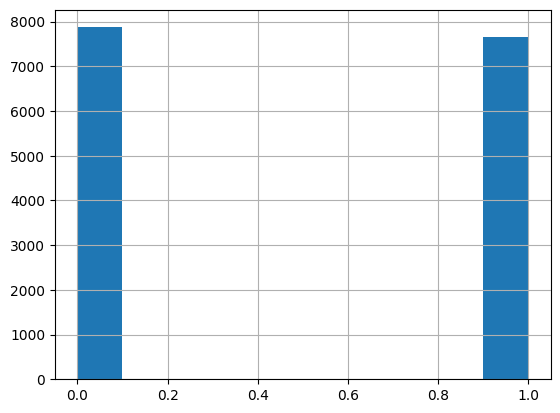

In [7]:
# drop nonfires
drop_nonfires_idx = train_ds[(train_ds.is_fire == 0)].index
assert drop_nonfires_idx.duplicated().sum() == 0
print(drop_nonfires_idx)
idx = drop_nonfires_idx.to_numpy()
np.random.shuffle(idx)
vc = train_ds.is_fire.value_counts()
a = -215
diff = vc[0] - vc[1] + a
print(diff, train_ds.shape[0])
drop_idx = idx[:diff]
print(drop_idx.shape)

train_ds = train_ds.drop(index=drop_idx)
train_ds = train_ds.reset_index(drop=True)
train_ds.is_fire.value_counts(), train_ds.is_fire.hist()

In [8]:
train_ds.columns

Index(['t_mean', 'wind_speed_mean', 'rh_mean', 'apcp_mean', 'wind_dir_std',
       'soilw10_mean', 'elevation', 'slope', 'aspect', 'road_dist',
       'river_dist', 'locality_dist', 'vegetation_type', 'event_date',
       'is_fire'],
      dtype='object')

In [9]:
train_ds.event_date.isnull().sum() == 0, test_ds.event_date.isnull().sum() == 0

(np.True_, np.True_)

In [10]:
train_ds.index, test_ds.index

(RangeIndex(start=0, stop=15533, step=1),
 RangeIndex(start=0, stop=1556, step=1))

In [11]:
# exclude cols in train_ds
ex_cols = []
train_ds_ = train_ds.loc[:, ~train_ds.columns.isin(ex_cols)]
train_ds_.columns, train_ds_.event_date.isnull().sum() == 0, train_ds_.shape

(Index(['t_mean', 'wind_speed_mean', 'rh_mean', 'apcp_mean', 'wind_dir_std',
        'soilw10_mean', 'elevation', 'slope', 'aspect', 'road_dist',
        'river_dist', 'locality_dist', 'vegetation_type', 'event_date',
        'is_fire'],
       dtype='object'),
 np.True_,
 (15533, 15))

In [12]:
train_ds_vif = train_ds_.loc[:, ~train_ds_.columns.isin(["is_fire", "event_date"])]
VIF = pd.DataFrame()
VIF["feature"] = list(train_ds_vif.columns)
VIF["VIF"] = [variance_inflation_factor(train_ds_vif.values, i) for i in range(train_ds_vif.shape[1])]
VIF

,feature,VIF
0,t_mean,3.441694
1,wind_speed_mean,1.381537
2,rh_mean,5.154706
3,apcp_mean,1.427783
4,wind_dir_std,1.214968
5,soilw10_mean,3.570503
6,elevation,1.817726
7,slope,1.672320
8,aspect,1.106674
9,road_dist,1.497428


(     t_mean  wind_speed_mean   rh_mean  apcp_mean  wind_dir_std  soilw10_mean  \
 0 -1.750273         1.728178  1.210773   0.905277     -0.650823      1.406636   
 1 -1.786003         1.670896  1.173733   0.282581     -0.550192      1.169801   
 2 -2.172439         1.055112  1.218934   0.697712      0.366810      0.459299   
 3 -1.859113         0.940547  1.158666   0.093886     -0.033866      1.525053   
 4 -0.614052         4.377482 -0.148403  -0.585419     -0.782845      1.761887   
 
    elevation     slope    aspect  road_dist  river_dist  locality_dist  \
 0  -0.855097  0.893102  1.294228   0.963490   -0.367656      -0.819439   
 1  -0.417496 -0.792476  0.918920   0.988931    0.837171       0.624715   
 2  -0.603039 -0.730377  0.150135   2.615564   -0.142636      -0.073070   
 3   0.685261  1.821564  1.398652   0.157983   -0.876581       0.938513   
 4   0.503219  1.520277  1.528360  -0.793166    2.769690      -0.848137   
 
    vegetation_type  
 0               15  
 1        

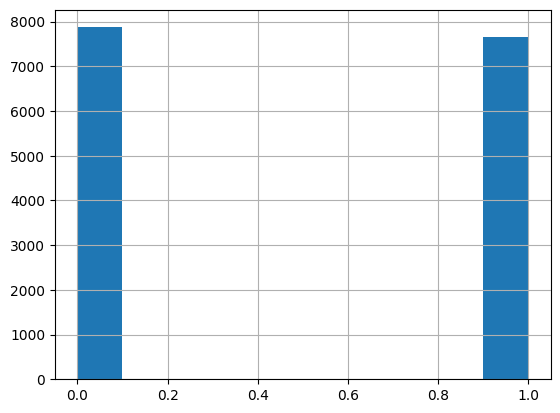

In [13]:
features = train_ds_.loc[:, ~train_ds_.columns.isin(["is_fire", "event_date"])]
target = train_ds_["is_fire"]
features = features.reset_index(drop=True)
target = target.reset_index(drop=True)
features.head(5), target.head(5), target.hist()

In [14]:
# normalize vegetation_type
vt = features.vegetation_type
transform_ = (vt - vt.mean()) / vt.std()

features_ex = features.copy()
features_ex.vegetation_type = transform_
features_ex.columns, #features_ex.vegetation_type

(Index(['t_mean', 'wind_speed_mean', 'rh_mean', 'apcp_mean', 'wind_dir_std',
        'soilw10_mean', 'elevation', 'slope', 'aspect', 'road_dist',
        'river_dist', 'locality_dist', 'vegetation_type'],
       dtype='object'),)

In [16]:
features_ex, target

(         t_mean  wind_speed_mean   rh_mean  apcp_mean  wind_dir_std  \
 0     -1.750273         1.728178  1.210773   0.905277     -0.650823   
 1     -1.786003         1.670896  1.173733   0.282581     -0.550192   
 2     -2.172439         1.055112  1.218934   0.697712      0.366810   
 3     -1.859113         0.940547  1.158666   0.093886     -0.033866   
 4     -0.614052         4.377482 -0.148403  -0.585419     -0.782845   
 ...         ...              ...       ...        ...           ...   
 15528 -0.676718         2.429886  0.960910   1.093973     -0.653404   
 15529 -0.647144         2.014589  0.544055  -0.321245     -0.654007   
 15530 -0.957612        -1.078651  0.044330  -0.623158      1.277295   
 15531 -1.437606        -1.393704  0.452397  -0.601593      1.837182   
 15532 -1.296444        -0.434226  0.640107  -0.601593      2.157542   
 
        soilw10_mean  elevation     slope    aspect  road_dist  river_dist  \
 0          1.406636  -0.855097  0.893102  1.294228   0.

(     t_mean  wind_speed_mean   rh_mean  apcp_mean  wind_dir_std  soilw10_mean  \
 0 -1.750273         1.728178  1.210773   0.905277     -0.650823      1.406636   
 1 -1.786003         1.670896  1.173733   0.282581     -0.550192      1.169801   
 2 -2.172439         1.055112  1.218934   0.697712      0.366810      0.459299   
 3 -1.859113         0.940547  1.158666   0.093886     -0.033866      1.525053   
 4 -0.614052         4.377482 -0.148403  -0.585419     -0.782845      1.761887   
 
    elevation     slope    aspect  road_dist  river_dist  locality_dist  \
 0  -0.855097  0.893102  1.294228   0.963490   -0.367656      -0.819439   
 1  -0.417496 -0.792476  0.918920   0.988931    0.837171       0.624715   
 2  -0.603039 -0.730377  0.150135   2.615564   -0.142636      -0.073070   
 3   0.685261  1.821564  1.398652   0.157983   -0.876581       0.938513   
 4   0.503219  1.520277  1.528360  -0.793166    2.769690      -0.848137   
 
    vegetation_type  
 0         0.323489  
 1        

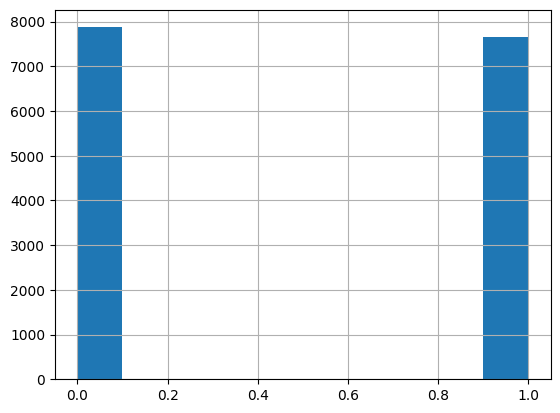

In [17]:
X_train_ds = features_ex.copy()
y_train_ds = target.copy()
X_train_ds.head(5), y_train_ds.head(5), X_train_ds.shape, y_train_ds.shape, y_train_ds.hist()

Prepare the test dataset so that it corresponds to the train ds

Is the X train and X test columns order equal? True
The target name: is_fire
     t_mean  wind_speed_mean   rh_mean  apcp_mean  wind_dir_std  soilw10_mean  \
0 -1.982983         1.651980  0.946560  -0.422448     -1.355052      0.713305   
1 -1.497209         0.109445  0.978408  -0.283478     -0.651410      1.139386   

   elevation     slope    aspect  road_dist  river_dist  locality_dist  \
0   5.225032  3.599040 -0.828978   0.235872   -0.469630      -0.695104   
1   0.754283  1.210331  1.390761  -0.743702   -0.655799      -0.808686   

   vegetation_type  
0         1.436138  
1         0.815579  
0       0
1       0
2       0
3       0
4       0
       ..
1551    0
1552    0
1553    0
1554    0
1555    0
Name: is_fire, Length: 1556, dtype: int64


<Axes: >

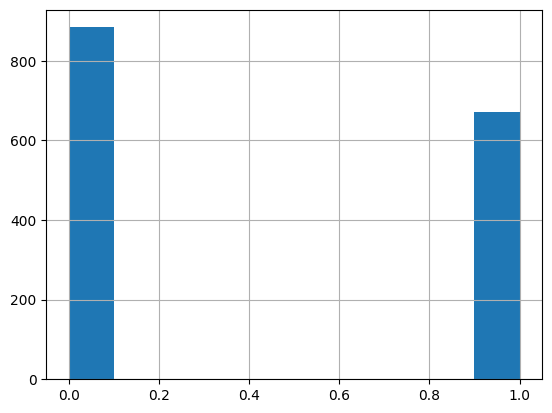

In [18]:
# prepare the test dataset

target_col = target.name
train_ds_cols = X_train_ds.columns.to_list() + [target_col]
test_ds_ = test_ds.loc[:, test_ds.columns.isin(train_ds_cols)]
# print(test_ds_.columns) #, test_ds_.head(1))
# test_ds_.is_fire.hist()

X_test_ds = test_ds_.loc[:, ~test_ds_.columns.isin([target_col])]
# # arrange X_test_ds so that its columns order corresponds to the X_train_ds (carefull! pd.DataFrame)
X_test_ds = X_test_ds.reindex(X_train_ds.columns, axis="columns")
# # assert that no NaN columns appeared after the reindex
assert X_test_ds.isnull().sum().sum() == 0
y_test_ds = test_ds_.loc[:, target_col]
print("Is the X train and X test columns order equal?", (X_train_ds.columns == X_test_ds.columns).all(), )
print("The target name:", y_test_ds.name)
# print(X_train_ds.head(2), X_test_ds.head(2), sep="\n")

# normalize X_test using z-score (like X_train)
# print("*" * 100, "Normalizing the test dataset", sep="\n")
X_test_ds = (X_test_ds - X_test_ds.mean()) / X_test_ds.std()
print(X_test_ds.head(2), y_test_ds, sep="\n")
y_test_ds.hist()

In [19]:
X_train_ds.shape, train_ds_

((15533, 13),
          t_mean  wind_speed_mean   rh_mean  apcp_mean  wind_dir_std  \
 0     -1.750273         1.728178  1.210773   0.905277     -0.650823   
 1     -1.786003         1.670896  1.173733   0.282581     -0.550192   
 2     -2.172439         1.055112  1.218934   0.697712      0.366810   
 3     -1.859113         0.940547  1.158666   0.093886     -0.033866   
 4     -0.614052         4.377482 -0.148403  -0.585419     -0.782845   
 ...         ...              ...       ...        ...           ...   
 15528 -0.676718         2.429886  0.960910   1.093973     -0.653404   
 15529 -0.647144         2.014589  0.544055  -0.321245     -0.654007   
 15530 -0.957612        -1.078651  0.044330  -0.623158      1.277295   
 15531 -1.437606        -1.393704  0.452397  -0.601593      1.837182   
 15532 -1.296444        -0.434226  0.640107  -0.601593      2.157542   
 
        soilw10_mean  elevation     slope    aspect  road_dist  river_dist  \
 0          1.406636  -0.855097  0.893102 

In [20]:
X_train_ds = X_train_ds.join(train_ds_["event_date"])
X_test_ds = X_test_ds.join(test_ds["event_date"])
print(X_train_ds.event_date.isnull().sum(), X_test_ds.event_date.isnull().sum())
X_train_ds.index.duplicated().sum() == 0, X_test_ds.index.duplicated().sum() == 0,

0 0


(np.True_, np.True_)

In [22]:
X_train_ds.head(5), y_train_ds.head(5)

(     t_mean  wind_speed_mean   rh_mean  apcp_mean  wind_dir_std  soilw10_mean  \
 0 -1.750273         1.728178  1.210773   0.905277     -0.650823      1.406636   
 1 -1.786003         1.670896  1.173733   0.282581     -0.550192      1.169801   
 2 -2.172439         1.055112  1.218934   0.697712      0.366810      0.459299   
 3 -1.859113         0.940547  1.158666   0.093886     -0.033866      1.525053   
 4 -0.614052         4.377482 -0.148403  -0.585419     -0.782845      1.761887   
 
    elevation     slope    aspect  road_dist  river_dist  locality_dist  \
 0  -0.855097  0.893102  1.294228   0.963490   -0.367656      -0.819439   
 1  -0.417496 -0.792476  0.918920   0.988931    0.837171       0.624715   
 2  -0.603039 -0.730377  0.150135   2.615564   -0.142636      -0.073070   
 3   0.685261  1.821564  1.398652   0.157983   -0.876581       0.938513   
 4   0.503219  1.520277  1.528360  -0.793166    2.769690      -0.848137   
 
    vegetation_type  event_date  
 0         0.323489 

In [23]:
X_test_ds.head(5), y_test_ds.head(5)

(     t_mean  wind_speed_mean   rh_mean  apcp_mean  wind_dir_std  soilw10_mean  \
 0 -1.982983         1.651980  0.946560  -0.422448     -1.355052      0.713305   
 1 -1.497209         0.109445  0.978408  -0.283478     -0.651410      1.139386   
 2 -1.679532         1.108420  1.049597   0.034168     -0.380244      1.139386   
 3 -1.661299         0.432643  1.082694   0.173139     -0.466278      1.032866   
 4 -1.551382         0.212280  1.007758  -0.144508     -0.724264      0.926345   
 
    elevation     slope    aspect  road_dist  river_dist  locality_dist  \
 0   5.225032  3.599040 -0.828978   0.235872   -0.469630      -0.695104   
 1   0.754283  1.210331  1.390761  -0.743702   -0.655799      -0.808686   
 2  -0.480496 -0.877701  0.626070   2.061805    0.012679       0.316273   
 3   0.541390  0.393388 -0.656251  -0.872888   -0.668769      -0.394442   
 4   0.868917 -0.065738  1.328163  -0.403708   -0.716960       0.198078   
 
    vegetation_type  event_date  
 0         1.436138 

In [24]:
# https://www.kaggle.com/code/szaitseff/classification-of-time-series-with-lstm-rnn/notebook
# time window for the net is 100 records (not days because the last 100 days may repeat because of the different coordinates)
time_window = 100

In [25]:
X_train_ds["event_date"] = pd.to_datetime(X_train_ds["event_date"])
X_test_ds["event_date"] = pd.to_datetime(X_test_ds["event_date"])

In [26]:
train_start_idx = X_train_ds[X_train_ds["event_date"].dt.month == 4].index[0]
test_start_idx = X_test_ds[X_test_ds["event_date"].dt.month == 4].index[0]
print(train_start_idx, test_start_idx)

274 253


In [27]:
X_train_ds.shape, len(X_train_ds), X_test_ds.shape, len(X_test_ds)

((15533, 14), 15533, (1556, 14), 1556)

In [28]:
X_train_ds = X_train_ds.loc[:, ~X_train_ds.columns.isin(["event_date"])]
X_test_ds = X_test_ds.loc[:, ~X_test_ds.columns.isin(["event_date"])]
X_train_ds.shape, len(X_train_ds), X_test_ds.shape, len(X_test_ds)

((15533, 13), 15533, (1556, 13), 1556)

In [29]:
# prepare train
X_train_l, y_train_l = [], []
for i in range(train_start_idx, len(X_train_ds)):
  x = X_train_ds.loc[i - time_window : i].values
  y = y_train_ds.loc[i]
  X_train_l.append(x)
  y_train_l.append(y)

X_train, y_train = np.array(X_train_l), np.array(y_train_l).reshape(-1, 1)
print(f"Train shape features: {X_train.shape}, target: {y_train.shape}")

Train shape features: (15259, 101, 13), target: (15259, 1)


In [30]:
# prepare test
X_test_l, y_test_l = [], []
for i in range(test_start_idx, len(X_test_ds)):
  x = X_test_ds.loc[i - time_window : i].values
  y = y_test_ds.loc[i]
  X_test_l.append(x)
  y_test_l.append(y)

X_test, y_test = np.array(X_test_l), np.array(y_test_l).reshape(-1, 1)
print(f"Test shape features: {X_test.shape}, target: {y_test.shape}")

Test shape features: (1303, 101, 13), target: (1303, 1)


##### Build and train the model

In [31]:
class ANNModel(keras_tuner.HyperModel):
  """
  The hypermodel class that builds the tf.keras.Sequential model and tunes its hyperparameters
  Params:
  input_shape: tuple - the shape of the train dataset in the following form: (n, ), where n is the
  number of train features
  """

  def __init__(self, input_shape: tuple) -> None:
    self.input_shape = input_shape


  def build_model(self, hp, n_layers: int, learning_rate: float, ) -> tf.keras.Sequential:
    """
    Description: build the model with the defined parameters
    Params: the model parameters we want to tune
    Returns: tf.keras.Sequential model
    """

    model = Sequential()

    model.add(Input(shape=self.input_shape))

    reg_l = [0.001, 0.01, 0.1, 0.]
    l2_reg_ = hp.Choice("lstm_activity_l2_reg_", reg_l)
    u1 = hp.Int(f"lstm_units", 8, 64, step=2, sampling="log")
    for i in range(n_layers):
      model.add(
          tf.keras.layers.LSTM(
              units=u1, return_sequences=True,
              bias_regularizer=rg.L1L2(l1=0, l2=l2_reg_),
          )
      )

    model.add(tf.keras.layers.Flatten())

    dense_layers = hp.Int("dense_layers", min_value=1, max_value=12, step=1)
    u2 = hp.Int(f"dense_units", 8, 1024, step=2, sampling="log")
    dr_o = hp.Float(f"drop_out_", 0.1, 0.3, step=0.05)
    for i in range(dense_layers):
      model.add(Dense(units=u2, activation="relu", bias_regularizer=rg.L2(0.01)))
      model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.Dropout(dr_o))
     
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy", "f1_score", tf.metrics.AUC()] #, "precision", "recall"])
    )

    print(f"I'm in build_model and I have the following params: {learning_rate, n_layers, u1, dense_layers, u2, dr_o}")

    return model


  def build(self, hp):
    """
    Description: build the model
    Params:
    hp - the hyperparameters class: keras_tuner.HyperParameters()
    Returns: the built model
    """

    n_layers = hp.Int("lstm_layers", min_value=1, max_value=4, step=1)
    l_rate = hp.Float("l_rate", min_value=1e-5, max_value=1e-1, step=10, sampling="log")

    model = self.build_model(hp, n_layers, l_rate)
    return model


  def fit(self, hp, model, x, y, batch_size = None, validation_split = None, **kwargs):
    """
    Description: fit the model
    Params:
    hp - the hyperparameters class: keras_tuner.HyperParameters()
    model - the model to fit (get in build)
    x, y - train features and train target respectively
    batch_size - the batch size
    validation_split - the validation split
    **kwargs - all the parameters that tf.keras.Model.fit method has
    """
    b_s = [32, 64, 128, 256, 512]
    if batch_size is None:
      batch_size = hp.Choice("b_size", b_s)
    print("I'm in fit and the batch size is", batch_size)

    v_s = [0.2, 0.15, 0.1, 0.25, 0.33]
    if validation_split is None:
      validation_split = hp.Choice("val_split", v_s)
    print("I'm in fit and the validation split is", validation_split)

    return model.fit(
        x, y,
        batch_size = batch_size,
        validation_split = validation_split,
        **kwargs,
    )

# usage
# input_shape = (X_train.shape[1], )
# hp = keras_tuner.HyperParameters()
# model = ANNModel(input_shape)
# m = model.build(hp)
# model.fit(hp, m, x=X_train, y=y_train)
# m.summary()

In [32]:
# create a path for the tuner
hp_tuner_path = "tuner_dir"
if not os.path.exists(hp_tuner_path):
  print("Creating the directory for the tuner. Path:", hp_tuner_path)
  os.mkdir(hp_tuner_path)

# a couple of variables to use in search and fit
callback_ = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min", start_from_epoch=3)
# if the values are None, tuner will use random search, else the specified value
batch_size_ = None
val_split_ = None

Creating the directory for the tuner. Path: tuner_dir


In [33]:
# input_shape = (X_train.shape[1], )
input_shape = X_train.shape[1:]
rs_tuner = keras_tuner.RandomSearch(
    ANNModel(input_shape),
    objective="val_loss",
    max_trials = 20,
    executions_per_trial = 1,
    overwrite = True,
    directory = hp_tuner_path,
    project_name = "fires"
)
rs_tuner.search(X_train, y_train, epochs=100, batch_size=batch_size_, validation_split=val_split_, callbacks=[callback_])

Trial 20 Complete [00h 00m 19s]
val_loss: 0.5798624753952026

Best val_loss So Far: 0.3440505862236023
Total elapsed time: 00h 30m 55s


In [34]:
rs_tuner.results_summary(), rs_tuner.get_best_hyperparameters()[0], rs_tuner.get_best_models()[0].summary()

Results summary
Results in tuner_dir/fires
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 00 summary
Hyperparameters:
lstm_layers: 3
l_rate: 0.001
lstm_activity_l2_reg_: 0.01
lstm_units: 32
dense_layers: 2
dense_units: 8
drop_out_: 0.2
b_size: 32
val_split: 0.2
Score: 0.3440505862236023

Trial 12 summary
Hyperparameters:
lstm_layers: 3
l_rate: 0.01
lstm_activity_l2_reg_: 0.01
lstm_units: 32
dense_layers: 3
dense_units: 8
drop_out_: 0.2
b_size: 256
val_split: 0.15
Score: 0.36324137449264526

Trial 09 summary
Hyperparameters:
lstm_layers: 4
l_rate: 0.01
lstm_activity_l2_reg_: 0.001
lstm_units: 8
dense_layers: 1
dense_units: 32
drop_out_: 0.15000000000000002
b_size: 32
val_split: 0.33
Score: 0.37946707010269165

Trial 18 summary
Hyperparameters:
lstm_layers: 3
l_rate: 0.01
lstm_activity_l2_reg_: 0.001
lstm_units: 16
dense_layers: 7
dense_units: 8
drop_out_: 0.15000000000000002
b_size: 128
val_split: 0.1
Score: 0.3869214951992035

Trial 11 summary
Hyperparameters

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 101, 32)        │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 101, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 101, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3232)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        25,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,537 (189.60 KB)

 Trainable params: 48,505 (189.47 KB)

 Non-trainable params: 32 (128.00 B)

(None,
 None)

In [35]:
best_model_epochs_ = 100
hp_model = ANNModel(input_shape)
best_hp_params = rs_tuner.get_best_hyperparameters()[0]
print("Refitting the model with the best hyperparams", best_hp_params.values)
tuned_model = hp_model.build(best_hp_params)
model_history = hp_model.fit(
    best_hp_params, tuned_model,
    X_train, y_train, epochs = best_model_epochs_,
    batch_size = batch_size_,
    validation_split = val_split_,
    callbacks = [callback_],
)

Refitting the model with the best hyperparams {'lstm_layers': 3, 'l_rate': 0.001, 'lstm_activity_l2_reg_': 0.01, 'lstm_units': 32, 'dense_layers': 2, 'dense_units': 8, 'drop_out_': 0.2, 'b_size': 32, 'val_split': 0.2}
I'm in build_model and I have the following params: (0.001, 3, 32, 2, 8, 0.2)
I'm in fit and the batch size is 32
I'm in fit and the validation split is 0.2
Epoch 1/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.7153 - auc_1: 0.7856 - f1_score: 0.6609 - loss: 1.3687 - val_accuracy: 0.7746 - val_auc_1: 0.8579 - val_f1_score: 0.6614 - val_loss: 0.9048
Epoch 2/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7802 - auc_1: 0.8513 - f1_score: 0.6693 - loss: 0.8244 - val_accuracy: 0.7749 - val_auc_1: 0.8672 - val_f1_score: 0.6614 - val_loss: 0.6545
Epoch 3/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7919 - auc_1: 0.8704 - f1_score: 0.6672 - loss: 0.5725 - val_accuracy: 0.8322 - val_auc_1: 0.9176 - val_f1_score: 0.6614 - val_loss: 0.4246

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 101, 32)        │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 101, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 101, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3232)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │        25,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,549 (568.55 KB)

 Trainable params: 48,505 (189.47 KB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 97,012 (378.96 KB)

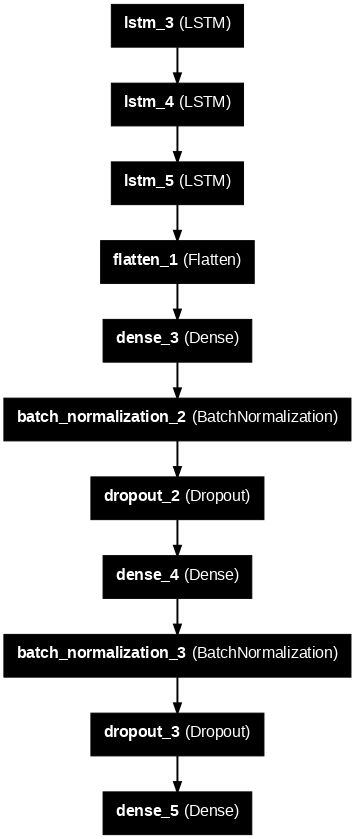

In [36]:
tuned_model.summary()
tf.keras.utils.plot_model(
    model=tuned_model, to_file="arch.png",
    # show_layer_activations=True, show_shapes=True,
    show_layer_names=True,
    dpi=70
)

Evaluate the results

In [37]:
print(tuned_model.evaluate(X_test, y_test))
tuned_model.metrics_names

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8181 - auc_1: 0.8801 - f1_score: 0.6970 - loss: 0.4777
[0.42720818519592285, 0.8380659818649292, 0.6751397848129272, 0.9054316282272339]


['loss', 'compile_metrics']

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
(1303, 1)
AUC score: 0.9054080170447046


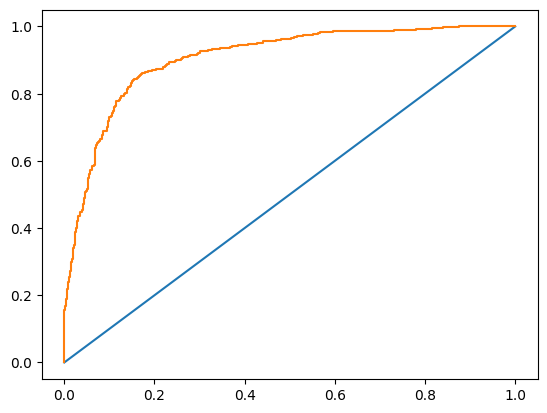

In [38]:
y_pred = tuned_model.predict(X_test)
print(y_pred.shape)
print("AUC score:", roc_auc_score(y_test, y_pred))
fpr, tpr, thresh = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)

In [39]:
import plotly.graph_objs as go

trace = go.Scatter(x=fpr, y=tpr, mode='lines', line=dict(color='darkorange', width=2), text=thresh)
reference_line = go.Scatter(x=[0,1], y=[0,1], mode='lines', name='Reference Line',
                            line=dict(color='navy', width=2, dash='dash'))
fig = go.Figure(data=[trace, reference_line])
fig.update_layout(title='Interactive ROC Curve',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate')
fig.show()

In [40]:
thresh_ = 0.5
y_pred_class = (y_pred > thresh_).astype(int)
print(y_pred_class.shape)
np.unique(y_pred_class)

(1303, 1)


array([0, 1])

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       639
           1       0.82      0.87      0.85       664

    accuracy                           0.84      1303
   macro avg       0.84      0.84      0.84      1303
weighted avg       0.84      0.84      0.84      1303



<Axes: >

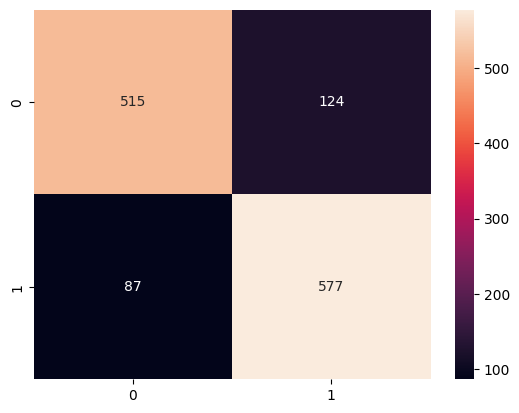

In [41]:
print(classification_report(y_true=y_test, y_pred=y_pred_class))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_class)
sns.heatmap(cm, annot=True, fmt="g")

In [42]:
# remove the keras_tuner folder
if os.path.exists(hp_tuner_path):
  print("Removing the hp tuner directory. Path:", hp_tuner_path)
  try:
    shutil.rmtree(hp_tuner_path)
  except Exception as e:
    print(e)

Removing the hp tuner directory. Path: tuner_dir


##### Save and load model

In [43]:
# add save history
model_dir_path = "data_and_models/"
if not os.path.exists(model_dir_path):
  os.mkdir(model_dir_path)

In [44]:
# save train and test data
# train_d = {"x_train" : X_train.tolist(), "y_train": y_train.tolist(), "ordered_train_columns" : X_train_ds.columns.tolist()}
# test_d = {"x_test": X_test.tolist(), "y_test": y_test.tolist(), "ordered_test_columns" : X_test_ds.columns.tolist()}

# with open(model_dir_path + "train_ds.json", "w") as f:
#   json.dump(train_d, f)

# with open(model_dir_path + "test_ds.json", "w") as f:
#   json.dump(test_d, f)

In [45]:
# save model in the different formats
tuned_model.save(model_dir_path + "model.keras", include_optimizer=True)
tuned_model.save(model_dir_path + "model.h5", include_optimizer=True)
tuned_model.save_weights(model_dir_path + "model.weights.h5")
with open(model_dir_path + "model_arch.json", "w") as f:
  json.dump(tuned_model.to_json(), f)

best_hp_params.values["epochs"] = best_model_epochs_
with open(model_dir_path + "model_params.json", "w") as f:
  json.dump(best_hp_params.values, f)

In [46]:
# save for shap and evaluation
%%bash
p=drive/MyDrive/vkr/train_data/for_shap/data_and_models_in_work
# echo $p
cp -r data_and_models/ $p